In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, f_regression, SelectFromModel, RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Embedding, Dot
from tensorflow.keras.layers import Activation, ReLU, LeakyReLU, PReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from functools import partial

# Data load

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Column 설정

In [5]:
target = 'target'

In [6]:
columns_useless = ['id']
# columns_useless = columns_useless + ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5']

In [7]:
columns_num_all = joblib.load('columns_num.pkl')
columns_cat_all = joblib.load('columns_cat.pkl')
columns_binary_num = joblib.load('columns_binary_num.pkl')
columns_binary_cat = joblib.load('columns_binary_cat.pkl')

In [8]:
try :
    columns_num_all.remove(target)
    
except :
    pass

In [9]:
try :
    columns_cat_all.remove(target)
    
except :
    pass

In [10]:
columns_num = []

for column in columns_num_all :
    
    if column not in columns_useless :
        columns_num.append(column)

In [11]:
columns_cat = []

for column in columns_cat_all :
    
    if column not in columns_useless :
        columns_cat.append(column)

In [12]:
columns_sc = []

for column in columns_num :
    
    if column not in columns_binary_num:
        columns_sc.append(column)
        
columns_sc

[]

In [13]:
columns_en = []

for column in columns_cat :
    
    if (column not in columns_binary_num) and (column not in columns_binary_cat):
        columns_en.append(column)
        
columns_en

['nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'ord_0',
 'day',
 'month']

# Target 분리

In [14]:
# y = data[target]
# X = data.drop(target, axis=1)

In [15]:
y_train = train[target]
X_train = train.drop(target, axis=1)
X_train_og = X_train.copy()

In [16]:
X_test = test.copy()

# 전체 dataset concat

In [17]:
all_data = pd.concat([X_train, X_test])

# Data preprocessing

In [18]:
def preprocessing(data, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en) :
    
    # useless column 제거
    data.drop(columns_useless, axis=1, inplace=True)
    
    # scaling
#     scaler = StandardScaler()
#     scaler.fit(X_train_og[columns_sc])
#     data[columns_sc] = scaler.transform(data[columns_sc])

    # binary data 처리
    column = columns_binary_cat[0]
    index_1 = data[data[column] == 'T'].index
    index_0 = data[data[column] == 'F'].index
    data.loc[index_1, column] = 1
    data.loc[index_0, column] = 0
    
    column = columns_binary_cat[1]
    index_1 = data[data[column] == 'Y'].index
    index_0 = data[data[column] == 'N'].index
    data.loc[index_1, column] = 1
    data.loc[index_0, column] = 0
    
    data[columns_binary_cat] = data[columns_binary_cat].astype('int64')
    
    # One-hot-encoding
#     data = pd.get_dummies(data, columns=columns_en)
    encoder = OneHotEncoder()   # 고윳값을 많이 가진 feature가 있는 경우는 OneHotEncoder를 사용해야 함
    data = encoder.fit_transform(data)
    
    return data

In [19]:
all_data = preprocessing(all_data, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en)

# Train & test set 분리

In [20]:
X_train = all_data[:len(train)]
X_test = all_data[len(train):]

# Validation set 분리
- Train dataset이 너무 커서 cross validation에 너무 오랜 시간이 걸리는 경우
- OneHotEncoder를 사용하면 sparse matrix를 return하기 때문에 neural network에서 validation_split를 사용할 수 없는 경우

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=30)

In [22]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)   # metrics로 'AUC'를 사용하기 위해 one-hot-encoding 사용
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

# Hidden layers = 10

In [23]:
def plot_result(history) :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b--', label='loss')
    plt.plot(history.history['val_loss'], 'r-', label='val_loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], 'b--', label='auc')
    plt.plot(history.history['val_auc'], 'r-', label='val_auc')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend()

In [24]:
np.random.seed(30)
tf.random.set_seed(30)

In [25]:
HiddenDense = partial(Dense, activation='selu', kernel_initializer='lecun_normal')

In [26]:
model = Sequential()
model.add(HiddenDense(100, input_shape=(X_train.shape[1],)))

for layer in range(10):
    model.add(HiddenDense(100))
    
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1655300   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [28]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [29]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [30]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=early_stopping_cb)

Epoch 1/100
7032/7032 [==============================] - 110s 16ms/step - loss: 0.5246 - auc: 0.8170 - val_loss: 0.5297 - val_auc: 0.8262
Epoch 2/100
7032/7032 [==============================] - 120s 17ms/step - loss: 0.4848 - auc: 0.8464 - val_loss: 0.5063 - val_auc: 0.8360
Epoch 3/100
7032/7032 [==============================] - 122s 17ms/step - loss: 0.4719 - auc: 0.8551 - val_loss: 0.4993 - val_auc: 0.8385
Epoch 4/100
7032/7032 [==============================] - 119s 17ms/step - loss: 0.4592 - auc: 0.8631 - val_loss: 0.5022 - val_auc: 0.8370
Epoch 5/100
7032/7032 [==============================] - 113s 16ms/step - loss: 0.4486 - auc: 0.8694 - val_loss: 0.5065 - val_auc: 0.8339
Epoch 6/100
7032/7032 [==============================] - 109s 16ms/step - loss: 0.4364 - auc: 0.8768 - val_loss: 0.5680 - val_auc: 0.7785
Epoch 7/100
7032/7032 [==============================] - 86s 12ms/step - loss: 0.4195 - auc: 0.8864 - val_loss: 0.5347 - val_auc: 0.8252
Epoch 8/100
7032/7032 [============

- loss: 0.4719
- auc: 0.8551
- val_loss: 0.4993
- val_auc: 0.8385

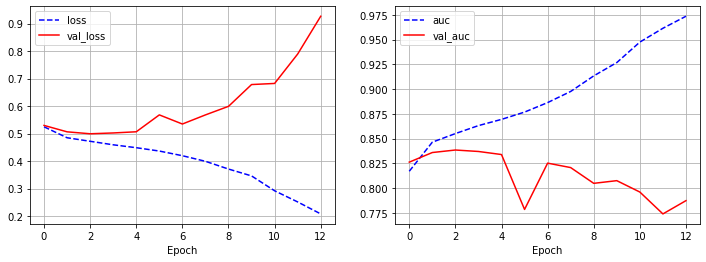

In [31]:
plot_result(history)

# Dropout 추가

In [32]:
HiddenDense = partial(Dense, activation='selu', kernel_initializer='lecun_normal')

In [33]:
model = Sequential()
model.add(HiddenDense(100, input_shape=(X_train.shape[1],)))

for layer in range(5):
    model.add(HiddenDense(100))
    model.add(HiddenDense(100))
    model.add(AlphaDropout(rate=0.2))
    
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               1655300   
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 100)              

In [34]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [35]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [36]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [37]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=early_stopping_cb)

Epoch 1/100
7032/7032 [==============================] - 73s 10ms/step - loss: 0.5289 - auc: 0.8143 - val_loss: 0.6971 - val_auc: 0.8293
Epoch 2/100
7032/7032 [==============================] - 73s 10ms/step - loss: 0.4873 - auc: 0.8452 - val_loss: 0.8107 - val_auc: 0.8219
Epoch 3/100
7032/7032 [==============================] - 72s 10ms/step - loss: 0.4788 - auc: 0.8552 - val_loss: 0.7152 - val_auc: 0.8323
Epoch 4/100
7032/7032 [==============================] - 69s 10ms/step - loss: 0.4602 - auc: 0.8632 - val_loss: 0.7030 - val_auc: 0.8296
Epoch 5/100
7032/7032 [==============================] - 68s 10ms/step - loss: 0.4518 - auc: 0.8688 - val_loss: 0.9785 - val_auc: 0.8282
Epoch 6/100
7032/7032 [==============================] - 68s 10ms/step - loss: 0.4415 - auc: 0.8733 - val_loss: 0.7893 - val_auc: 0.8095
Epoch 7/100
7032/7032 [==============================] - 69s 10ms/step - loss: 0.4476 - auc: 0.8781 - val_loss: 1.1243 - val_auc: 0.8036
Epoch 8/100
7032/7032 [==================

- loss: 0.4788
- auc: 0.8552
- val_loss: 0.7152
- val_auc: 0.8323

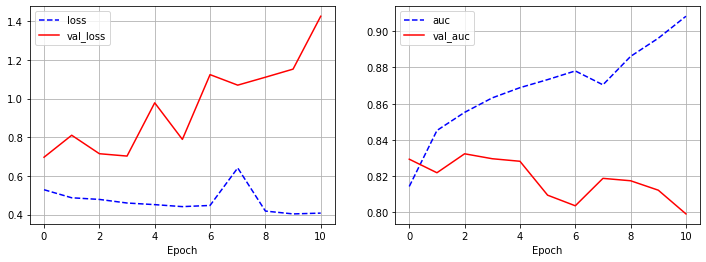

In [38]:
plot_result(history)

# Dropout 추가 2

In [39]:
HiddenDense = partial(Dense, activation='selu', kernel_initializer='lecun_normal')

In [40]:
model = Sequential()
model.add(HiddenDense(100, input_shape=(X_train.shape[1],)))

for layer in range(10):
    model.add(HiddenDense(100))
    model.add(AlphaDropout(rate=0.2))
    
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 100)               1655300   
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout_5 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout_6 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout_7 (AlphaDropou (None, 100)              

In [41]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [43]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [44]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=early_stopping_cb)

Epoch 1/100
7032/7032 [==============================] - 80s 11ms/step - loss: 0.5466 - auc: 0.7982 - val_loss: 1.8925 - val_auc: 0.8179
Epoch 2/100
7032/7032 [==============================] - 82s 12ms/step - loss: 0.4895 - auc: 0.8439 - val_loss: 2.0409 - val_auc: 0.7842
Epoch 3/100
7032/7032 [==============================] - 80s 11ms/step - loss: 0.4754 - auc: 0.8537 - val_loss: 1.3527 - val_auc: 0.8201
Epoch 4/100
7032/7032 [==============================] - 80s 11ms/step - loss: 0.4710 - auc: 0.8587 - val_loss: 1.5809 - val_auc: 0.7848
Epoch 5/100
7032/7032 [==============================] - 82s 12ms/step - loss: 0.4554 - auc: 0.8657 - val_loss: 2.1771 - val_auc: 0.8049
Epoch 6/100
7032/7032 [==============================] - 94s 13ms/step - loss: 0.4452 - auc: 0.8718 - val_loss: 2.1064 - val_auc: 0.7985
Epoch 7/100
7032/7032 [==============================] - 146s 21ms/step - loss: 0.4403 - auc: 0.8746 - val_loss: 2.4614 - val_auc: 0.8040
Epoch 8/100
7032/7032 [=================

- loss: 0.4754
- auc: 0.8537
- val_loss: 1.3527
- val_auc: 0.8201

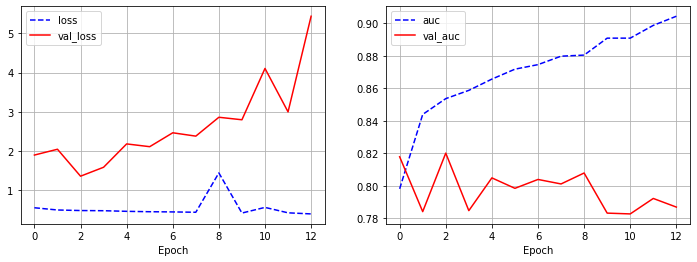

In [45]:
plot_result(history)

# Dropout rate 증대

In [46]:
HiddenDense = partial(Dense, activation='selu', kernel_initializer='lecun_normal')

In [47]:
model = Sequential()
model.add(HiddenDense(100, input_shape=(X_train.shape[1],)))

for layer in range(10):
    model.add(HiddenDense(100))
    model.add(AlphaDropout(rate=0.4))
    
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 100)               1655300   
_________________________________________________________________
dense_37 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout_15 (AlphaDropo (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout_16 (AlphaDropo (None, 100)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 100)               10100     
_________________________________________________________________
alpha_dropout_17 (AlphaDropo (None, 100)              

In [48]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [49]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [50]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [51]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=early_stopping_cb)

Epoch 1/100
7032/7032 [==============================] - 85s 12ms/step - loss: 0.5484 - auc: 0.7973 - val_loss: 10.6518 - val_auc: 0.7606
Epoch 2/100
7032/7032 [==============================] - 83s 12ms/step - loss: 0.4928 - auc: 0.8418 - val_loss: 12.9389 - val_auc: 0.7732
Epoch 3/100
7032/7032 [==============================] - 84s 12ms/step - loss: 0.4776 - auc: 0.8524 - val_loss: 11.5186 - val_auc: 0.7646
Epoch 4/100
7032/7032 [==============================] - 85s 12ms/step - loss: 0.4669 - auc: 0.8595 - val_loss: 7.7596 - val_auc: 0.7900
Epoch 5/100
7032/7032 [==============================] - 97s 14ms/step - loss: 0.4574 - auc: 0.8656 - val_loss: 14.7001 - val_auc: 0.7545
Epoch 6/100
7032/7032 [==============================] - 102s 15ms/step - loss: 0.4490 - auc: 0.8708 - val_loss: 10.8132 - val_auc: 0.7380
Epoch 7/100
7032/7032 [==============================] - 104s 15ms/step - loss: 0.4409 - auc: 0.8750 - val_loss: 15.5762 - val_auc: 0.7643
Epoch 8/100
7032/7032 [==========

- loss: 0.4669
- auc: 0.8595
- val_loss: 7.7596
- val_auc: 0.7900

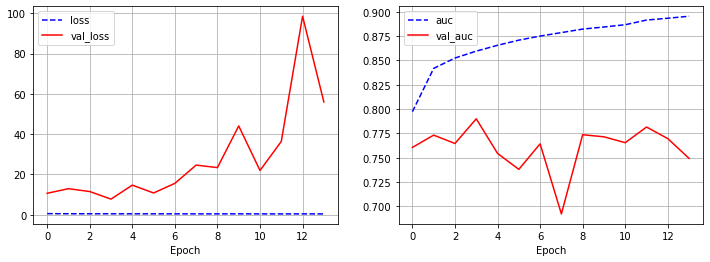

In [52]:
plot_result(history)

# 1 cycle scheduling & dropout 제거

In [53]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = X.shape[0] // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.figure(figsize=(10, 6))
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.axis([min(rates), max(rates), min(losses) * 0.9, (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [54]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, last_rate=None, last_iterations=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) / (iter2 - iter1) * (self.iteration - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
            
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_rate, self.start_rate)
            
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
            
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

## Find learning rate 

In [55]:
HiddenDense = partial(Dense, activation='selu', kernel_initializer='lecun_normal')

In [56]:
model = Sequential()
model.add(HiddenDense(100, input_shape=(X_train.shape[1],)))

for layer in range(10):
    model.add(HiddenDense(100))
    
model.add(Dense(2, activation='softmax'))

In [57]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [58]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])

7032/7032 [==============================] - 93s 13ms/step - loss: 20.0775 - auc: 0.6552


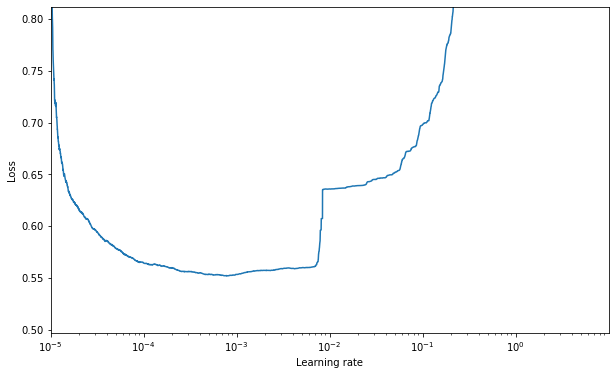

In [59]:
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1)
plot_lr_vs_loss(rates, losses)

In [60]:
max_rate = 0.001

- learning rate 0.001로 선정

## 1 cycle scheduling

In [61]:
model = Sequential()
model.add(HiddenDense(100, input_shape=(X_train.shape[1],)))

for layer in range(5):
    model.add(HiddenDense(100))
    
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 100)               1655300   
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_63 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_64 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_65 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_66 (Dense)             (None, 2)                

In [62]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [63]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [64]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [65]:
batch_size = 32
n_epochs = 100
onecycle_cb = OneCycleScheduler(X_train.shape[0] // batch_size * n_epochs, max_rate=0.05)

In [66]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), callbacks=[early_stopping_cb, onecycle_cb])

Epoch 1/100
7032/7032 [==============================] - 83s 12ms/step - loss: 0.5479 - auc: 0.8034 - val_loss: 0.5764 - val_auc: 0.7748
Epoch 2/100
7032/7032 [==============================] - 82s 12ms/step - loss: 0.5305 - auc: 0.8290 - val_loss: 0.5050 - val_auc: 0.8386
Epoch 3/100
7032/7032 [==============================] - 84s 12ms/step - loss: 0.7781 - auc: 0.7311 - val_loss: 0.6158 - val_auc: 0.6949
Epoch 4/100
7032/7032 [==============================] - 85s 12ms/step - loss: 0.6532 - auc: 0.6876 - val_loss: 0.6163 - val_auc: 0.6949
Epoch 5/100
7032/7032 [==============================] - 85s 12ms/step - loss: 0.6617 - auc: 0.6840 - val_loss: 0.6439 - val_auc: 0.6949
Epoch 6/100
7032/7032 [==============================] - 85s 12ms/step - loss: 0.6640 - auc: 0.6824 - val_loss: 0.7802 - val_auc: 0.6949
Epoch 7/100
7032/7032 [==============================] - 79s 11ms/step - loss: 0.6651 - auc: 0.6824 - val_loss: 0.6205 - val_auc: 0.6949
Epoch 8/100
7032/7032 [==================

- 성능의 변화가 거의 없이 정체됨
- loss: 0.5305
- auc: 0.8290
- val_loss: 0.5050
- val_auc: 0.8386

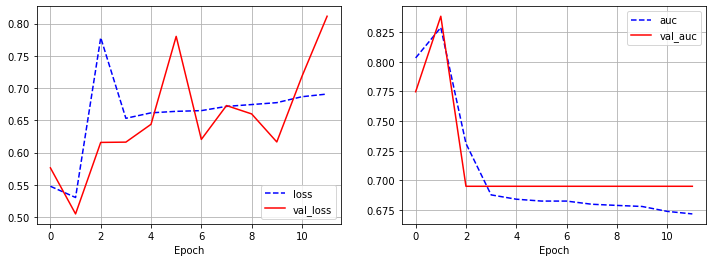

In [67]:
plot_result(history)